<a href="https://colab.research.google.com/github/harakenken22/diveintocode-ml/blob/master/Sprint18_Augmentation_BBOX_KH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sprint18 [問題4] 物体検出用データ拡張

コード参照：
https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
%matplotlib inline
from urllib.request import urlopen

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)
import glob
import os

import pprint

In [31]:
# 画像読み込み

def load_image(jpg):
    img = cv2.imread(jpg)
    return img

In [32]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=15):
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    #plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [33]:
# 関数化しておく

def get_aug(aug):
    return Compose(aug, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_id']})

In [34]:
# labelimgでxmlファイル（PascalVOC形式bbox）を作成済み

im_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/*'))
im_list

['/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.01.jpg',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.01.xml',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.02.jpg',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.02.xml',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.03.jpg',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.03.xml',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.04.jpg',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.04.xml',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.05.jpg',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.05.xml',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.07.xml']

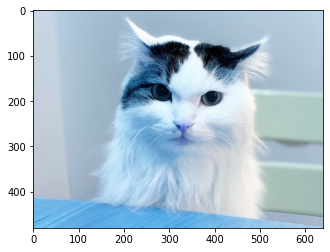

In [35]:
# データチェック

img = load_image('/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/cat.01.jpg')
plt.imshow(img)
plt.show()

## xmlデータ構造をパース（分析）して座標情報を獲得する

In [36]:
import os
import xml.etree.ElementTree as ET


# #読み込み例
# tree = ET.parse(path + 'cat.41box.xml')
# #一番上の階層
# root = tree.getroot()

COORDINATE = 4

path = '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/training/cat/'
boxbox = []
point = COORDINATE

for filename in os.listdir(path):
    
    boundbox = []    
    if not filename.endswith('.xml'): 
        continue
       
    fullname = os.path.join(path, filename)
    tree = ET.parse(fullname)
    
    bndbox = tree.findall('object/bndbox')
    
    for i in range(point):
        # 座標取得
        boundbox.append(bndbox[0][i].text)
    boxbox.append(boundbox)
    
boxbox   

[['151', '21', '527', '338'],
 ['137', '36', '590', '527'],
 ['33', '46', '452', '400'],
 ['177', '12', '532', '350'],
 ['266', '1', '635', '361'],
 ['51', '4', '288', '200']]

In [37]:
print(boxbox)

[['151', '21', '527', '338'], ['137', '36', '590', '527'], ['33', '46', '452', '400'], ['177', '12', '532', '350'], ['266', '1', '635', '361'], ['51', '4', '288', '200']]


## データ拡張

In [38]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298

# 座標は手入力
annotations = {'image': img, 'bboxes': [[151, 21, 527, 338]], 'category_id': [1]}
category_id_to_name = {1: 'cat'}

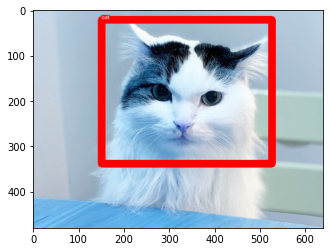

In [39]:
visualize(annotations, category_id_to_name)

{'image': array([[[106, 189, 244],
        [106, 189, 244],
        [107, 190, 242],
        ...,
        [179, 207, 231],
        [181, 209, 233],
        [184, 212, 236]],

       [[104, 187, 242],
        [104, 187, 242],
        [104, 187, 239],
        ...,
        [176, 202, 226],
        [175, 201, 225],
        [176, 202, 226]],

       [[102, 185, 240],
        [102, 185, 240],
        [102, 185, 237],
        ...,
        [162, 186, 208],
        [159, 183, 205],
        [159, 183, 205]],

       ...,

       [[200, 215, 231],
        [200, 215, 231],
        [199, 214, 230],
        ...,
        [188, 210, 228],
        [188, 210, 228],
        [189, 211, 229]],

       [[200, 215, 231],
        [200, 215, 231],
        [199, 214, 230],
        ...,
        [189, 211, 229],
        [189, 211, 229],
        [189, 211, 229]],

       [[200, 215, 231],
        [200, 215, 231],
        [200, 215, 231],
        ...,
        [190, 212, 230],
        [189, 211, 229],
        [189, 

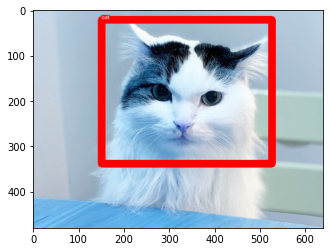

In [40]:
transform = Compose([VerticalFlip(p=1)],bbox_params={'format': 'pascal_voc', 'label_fields': ['category_id']})
transformed = transform(**annotations)
visualize(annotations, category_id_to_name)

# Composeの中身を表示
print(transform)
# 変換後のimage arrayとbboxとcategory_id
print(transformed)

{'image': array([[[189, 211, 229],
        [189, 211, 229],
        [190, 212, 230],
        ...,
        [200, 215, 231],
        [200, 215, 231],
        [200, 215, 231]],

       [[189, 211, 229],
        [189, 211, 229],
        [189, 211, 229],
        ...,
        [199, 214, 230],
        [200, 215, 231],
        [200, 215, 231]],

       [[189, 211, 229],
        [188, 210, 228],
        [188, 210, 228],
        ...,
        [199, 214, 230],
        [200, 215, 231],
        [200, 215, 231]],

       ...,

       [[159, 183, 205],
        [159, 183, 205],
        [162, 186, 208],
        ...,
        [102, 185, 237],
        [102, 185, 240],
        [102, 185, 240]],

       [[176, 202, 226],
        [175, 201, 225],
        [176, 202, 226],
        ...,
        [104, 187, 239],
        [104, 187, 242],
        [104, 187, 242]],

       [[184, 212, 236],
        [181, 209, 233],
        [179, 207, 231],
        ...,
        [107, 190, 242],
        [106, 189, 244],
        [106, 

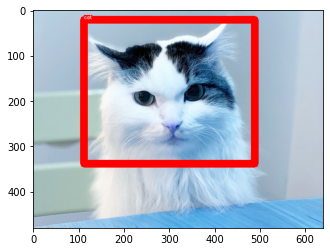

In [41]:
# get_augで実行

transform = get_aug([HorizontalFlip(p=1)])
transformed = transform(**annotations)
visualize(transformed, category_id_to_name)

# 変換後のimage arrayとbboxとcategory_id
print(transformed)

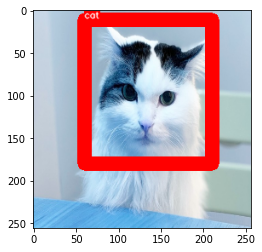

In [42]:
transform = get_aug([Resize(p=1, height=256, width=256)])
transformed = transform(**annotations)
visualize(transformed, category_id_to_name)

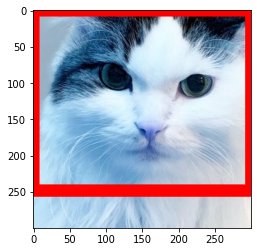

In [43]:
transform = get_aug([CenterCrop(p=1, height=300, width=300)])
transformed = transform(**annotations)
visualize(transformed, category_id_to_name)

----------------
おまけ

## keras-yolo3
### voc_annotation.py の実行

In [ ]:
'''python voc_annotation.py の分析

voc_annotation.pyのコードを犬猫データセット用に書き換えてみる

https://github.com/qqwweee/keras-yolo3
'''

def convert_annotation(classes, path, image_name, annotation):
    
    in_file = open(path + f'{image_name}.xml')
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        annotation.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

In [ ]:
# 実行

classes = ['dog', 'cat']

# 空のtxtファイルを用意する
annotation = open('annotation.txt', 'w')

im_list = sorted(glob.glob('./training/*' + '.jpg'))
im_list

for im in im_list:
    annotation.write(im)
    im_name = im.lstrip(path).rstrip('.jpg')
    convert_annotation(classes, path, im_name, annotation)
    annotation.write('\n')
        
annotation.close()
# annotation.txtを開くと、keras-yolo3のtrain.txt形式のアノテーション情報が書き込まれている